# Image Generation via Generative Adversarial Networks

## import libraries

In [1017]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [1018]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [1019]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [1020]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

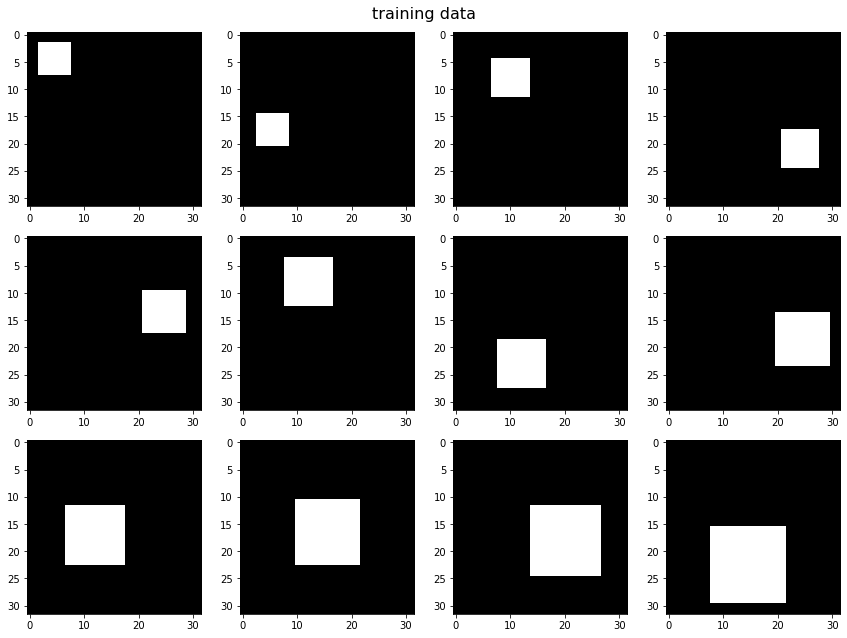

In [1021]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [1022]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [1023]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1024]:
print(device)

cpu


## construct datasets and dataloaders 

In [1025]:
size_minibatch  = 10
dim_latent      = 100

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [1026]:
class Discriminator(nn.Module):
    
  def __init__(self):
      super(Discriminator, self).__init__()

      self.linear1 = nn.Linear(32*32, 1024)
      self.linear2 = nn.Linear(1024, 512)
      self.linear3 = nn.Linear(512, 256)
      self.linear4 = nn.Linear(256, 1)
      self.leaky_relu = nn.LeakyReLU(0.2)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.leaky_relu(self.linear1(x))
      x = self.leaky_relu(self.linear2(x))
      x = self.leaky_relu(self.linear3(x))
      x = self.linear4(x)
      x = self.sigmoid(x)
      return x

In [1027]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(dim_latent, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 1024)
        self.linear4 = nn.Linear(1024, 32*32)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = self.tanh(x)
        return x

## build network

In [1028]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

learning_rate = 0.0000001

criterion = torch.nn.BCELoss()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)


## compute the prediction

In [1029]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [1030]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1]) 
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [1031]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [1032]:

def train(generator, discriminator, dataloader):
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])
        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()

        real_label = torch.full((size_minibatch, 1), 1, dtype=torch.float32).to(device)
        fake_label = torch.full((size_minibatch, 1), 0, dtype=torch.float32).to(device)


        real_images = real.reshape(size_minibatch, -1).to(device)

        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()


        fake_images = generator(latent)


        gen_loss = criterion(discriminator(fake_images), real_label)

        gen_loss.backward()
        gen_optimizer.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()
        
        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()

        fake_images = generator(latent)


        fake_loss = criterion(discriminator(fake_images), fake_label)
        real_loss = criterion(discriminator(real_images), real_label)
        dis_loss = (fake_loss + real_loss) / 2

        dis_loss.backward()
        dis_optimizer.step()


    
    '''for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        fake_data = generator(latent)
        gen_prediction = compute_prediction(generator, fake_data)
        loss = torch.nn.BCELoss()(gen_prediction, real)
        
        gen_optimizer.zero_grad()
        loss.backward()
        gen_optimizer.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()

        dis_prediction = compute_prediction(discriminator, latent)
        loss = torch.nn.BCELoss()(prediction, real)
 
        dis_optimizer.zero_grad()
        loss.backward()
        dis_optimizer.step()'''


## test

In [1033]:
def test(generator, latent):
    
    generator.eval()
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [1034]:
number_epoch    = 10
accuracy_epoch  = np.zeros(number_epoch)

num_latent_test = 10
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1]) 

for i in tqdm(range(number_epoch)):
    train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x1 and 100x256)

---

# functions for presenting the results

---

In [ ]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



TypeError: Invalid shape (1024,) for image data

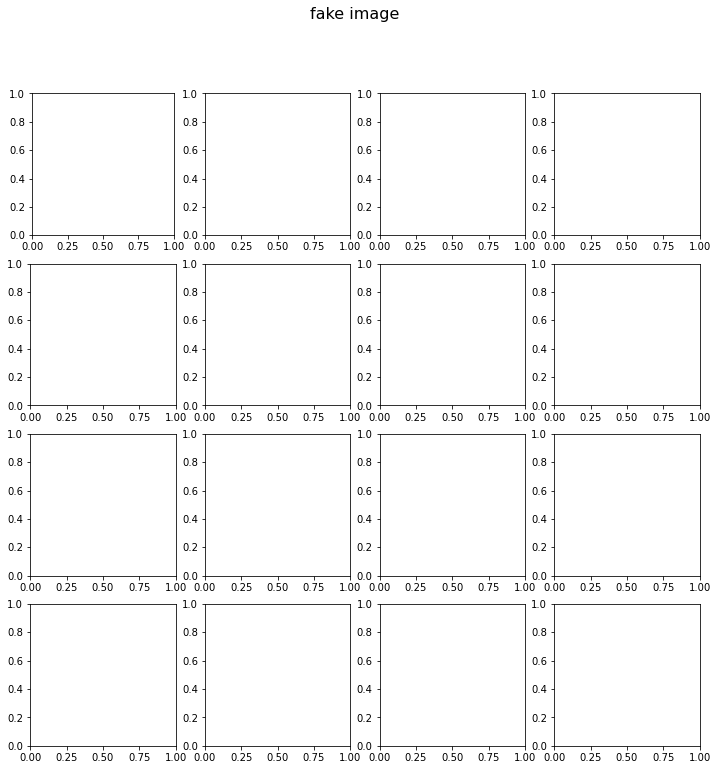

In [ ]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)